# Simulation Study Code

## Section 4 + Supplementary Material B 1
-------------------------------------

This notebook was used to run the "Section 4: Simulation Study". For each variation the source, sensor setting, or atmospheric condition was modified. The results and plots used in the paper are presented in the notebook: "Simulation Study Plots.ipynb".

<div class="alert alert-block alert-warning">
<b>PACKAGE REQUIREMENT:</b> Package "sourceinversion". Install using:<br>
pip install -q sourceinversion
</div>

In [1]:
# pip install -q sourceinversion

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/...
</div>

<br><br><br>

### Importing "sourceinversion" package 

In [2]:
import sourceinversion.atmospheric_measurements as gp
import sourceinversion.mcmc as mcmc

### Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
from jax import config
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import itertools
from jax import lax
from pyDOE import lhs

config.update("jax_enable_x64", True)



<br>

## 1. Simulating Gas Sensors' Layout

In [4]:
number_of_sensors = 36
layout = "grid"

### 1.1. Grid of Sensors

In [5]:
grid_sensor_locations = gp.SensorsSettings.grid_of_sensors(p1 = (100,5,1), p2 = (100,5,20), p3 = (100,95,1), p4 = (100,95,20), num_points=number_of_sensors, formation=layout)

<div class="alert alert-block alert-info">
<b>Note:</b> Here we use the "Grid Layout" and therefore set it as our sensor setting:
</div>

In [6]:
sensors_settings =  gp.SensorsSettings(
    layout = layout,
    sensor_number = jnp.array(number_of_sensors),
    measurement_error_var = jnp.array(1e-6),
    sensor_seed = jnp.array(5),
    measurement_error_seed = jnp.array(420),
    sensor_locations = grid_sensor_locations,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### 1.2. Alternative Sensor Layouts

#### 1.2.1 Random Sensor Location

In [7]:
random_sensor_locations = gp.SensorsSettings.random_sensor_locations(num_sensors = 36, x_range = (0, 100), y_range = (0, 100), z_range = (0, 5))

#### 1.2.2 Circle of Sensors

In [8]:
circle_sensor_locations = gp.SensorsSettings.circle_of_sensors(num_sensors = 10 , center = np.array([50.0, 50.0, 3.0]), radius = 40.0)

### 1.3 Sensor Layouts Visualisation

#### 1.3.1 Grid Layout

/home/newmant1/Desktop/transfert to one drive/Code/Code Research Lab/Paper 2 Code/paper_2_venv/lib/python3.10/site-packages/sourceinversion/atmospheric_measurements/atmospheric_measurements.py:325: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coords[i], y_coords[i], z_coords[i], s=55, c=colors[i], marker='*')


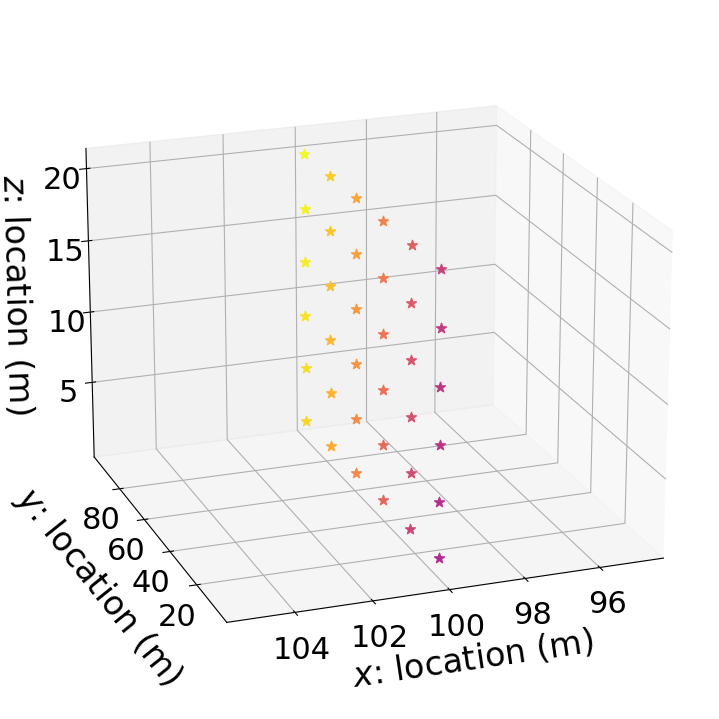

In [9]:
gp.SensorsSettings.plot_points_3d(grid_sensor_locations, save = False)

#### 1.3.2 Random Layout

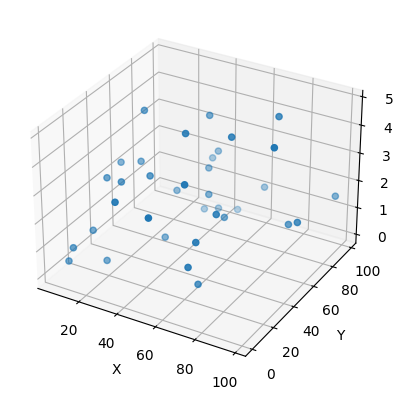

In [10]:
gp.SensorsSettings.plot_sensor_location(random_sensor_locations, save=False)

#### 1.3.3 Circle Layout

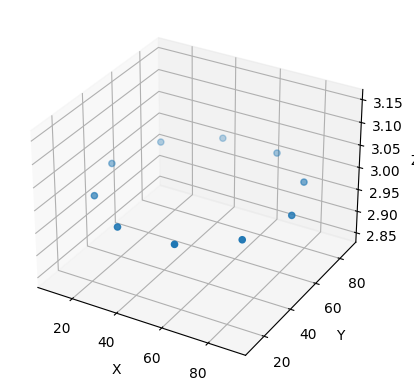

In [11]:
gp.SensorsSettings.plot_sensor_location(circle_sensor_locations, save=False)

<br>

## 2. Simulating Sources and Atmospheric Conditions

### 2.1 Simulation

In [12]:
# Grid specification based on the Chilbolton terrain dimensions (used for Grid-based inversion)
grid = gp.Grid(
    x_range = (jnp.array(0.0), jnp.array(110.0)), 
    y_range = (jnp.array(0.0), jnp.array(110.0)),
    z_range= (jnp.array(0), jnp.array(0)),
    dx = jnp.array(0.1),
    dy = jnp.array(0.1),
    dz = jnp.array(1),
)

# Source location
source_location = gp.SourceLocation(
    source_location_x = jnp.array([50.0]),
    source_location_y = jnp.array([50.0]),
    source_location_z = jnp.array([5.0]),
)

# Wind field
wind_field = gp.WindField(
    Ornstein_Uhlenbeck = False,
    initial_wind_speed = jnp.array(6.0),
    initial_wind_direction = jnp.array(-70),
    end_wind_direction = jnp.array(70),
    number_of_time_steps = int(jnp.array(100)),
    time_step = jnp.array(1.0),
    wind_speed_temporal_std = jnp.array(0.1),
    wind_direction_temporal_std = jnp.array(10.0),
    wind_temporal_correlation = jnp.array(0.5),
    wind_speed_seed = 2,
    wind_direction_seed = 4,
)

# Atmospheric state
atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array([0.00039]),           # 0.00039kg/s = 1.41kg/h. To scale parameter like distances (0.00039 * 100_000) = 39.0
    source_half_width = jnp.array(0.5),             # source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(2.0),       
    background_std = jnp.array(1e-2),       
    background_seed = jnp.array(56),
    background_filter = "power_law",        
    Gaussian_filter_kernel = 1,
    horizontal_opening_angle= 10.0,
    vertical_opening_angle = 10.0,
    a_horizontal = 1.0,
    a_vertical = 1.0,          
    b_horizontal = 1.0,
    b_vertical = 1.0,  
)

### 2.2 Visualisation

#### 2.2.1 Gaussian Plume Model Gas Concentrations

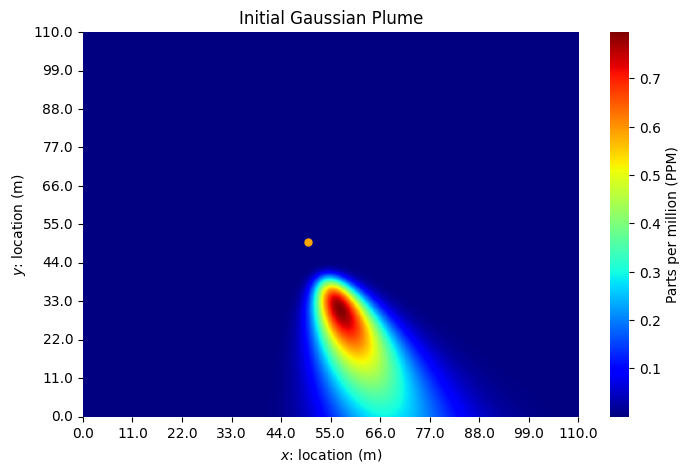

In [13]:
gaussianplume = gp.GaussianPlume(grid, source_location, wind_field, atmospheric_state, sensors_settings)
gaussianplume.gaussian_plume_plot(log_scale = False, save=False, format='png')

#### 2.2 Background Concentration

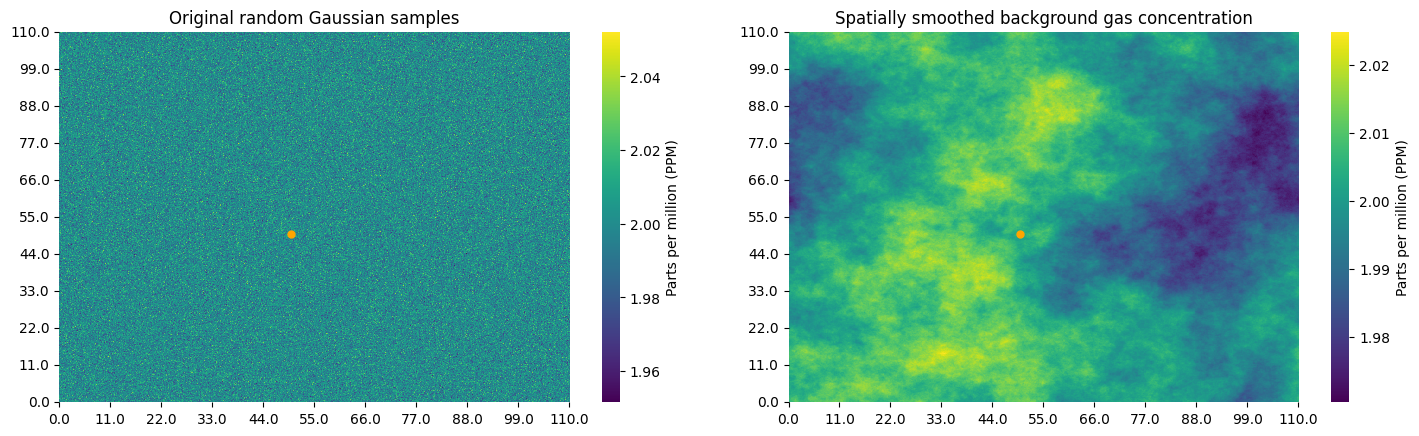

In [14]:
background = gp.BackgroundGas(grid, source_location, atmospheric_state)
background.background_plot(save=False, format='png')

### 2.3 Wind Field

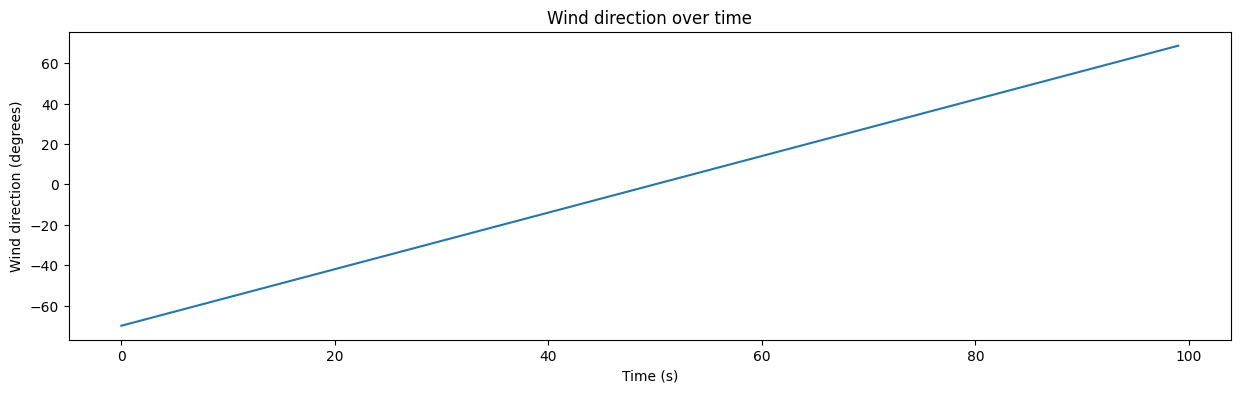

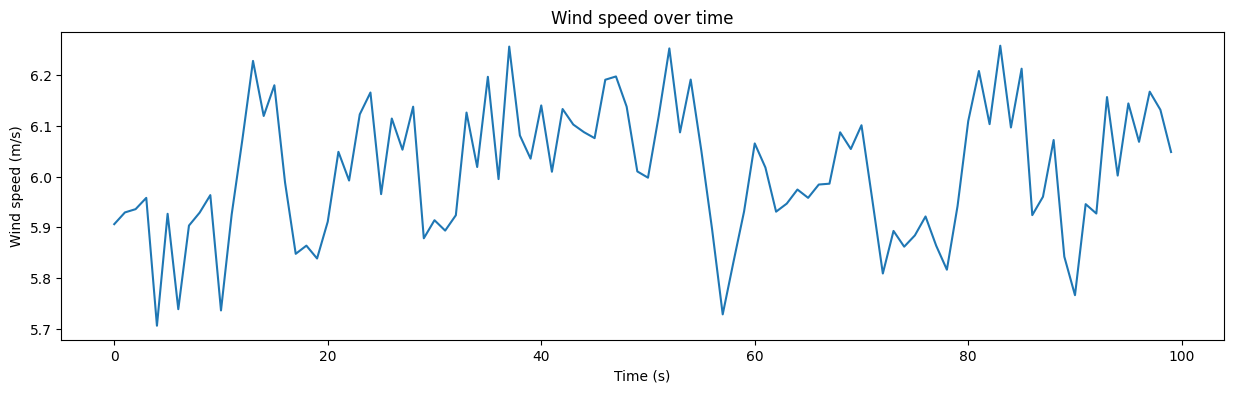

In [15]:
gaussianplume.wind_direction_plot(save=False, format='png')
gaussianplume.wind_speed_plot(save=False, format='png')

<br>

## 3. Simulating Sensor Gas Measurements

In [16]:
sensors = gp.Sensors(gaussianplume, background, sensors_settings)

### 3.1 Simulating Data

In [17]:
# True source and atmospheric parameter values and sensor measurement data
truth = sensors.temporal_sensors_measurements(grided=False, beam=False)
# Data
data = truth[0]

### 3.2 Visualisation

#### 3.2.1 Sensor Layout, Background Concentration and Gaussian Plume Model

<Figure size 1000x1000 with 0 Axes>

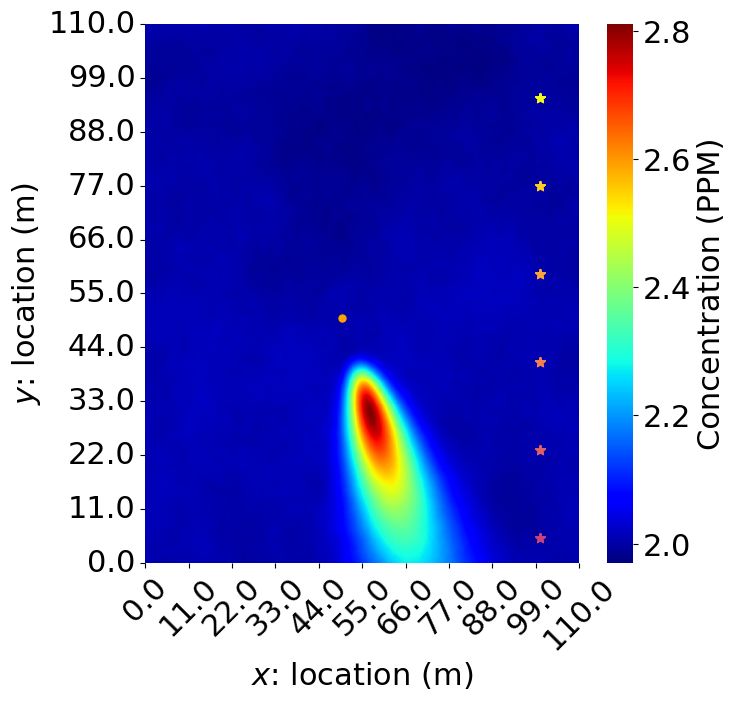

In [18]:
sensors.atmospheric_methane_and_sensors(save=False, format='png')

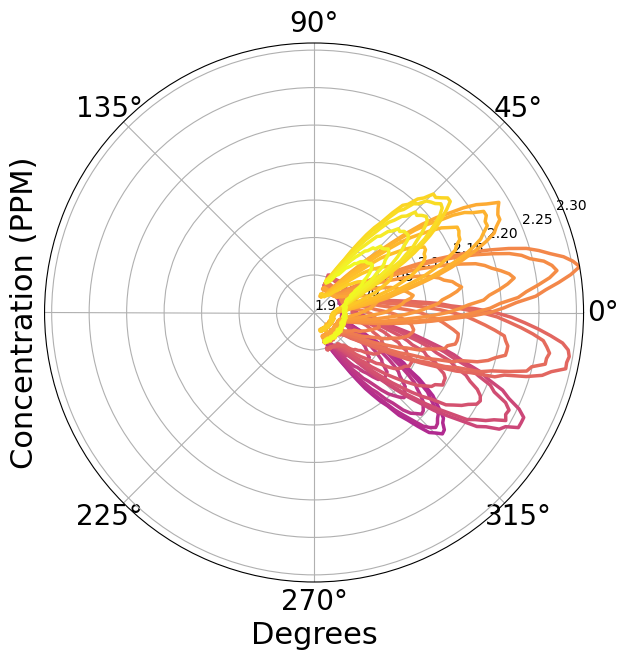

In [19]:
sensors.plot_polar_graph(save = False)

<br><br><br><br><br>

## 4. Source and Atmospheric Parameter Estimation

In [20]:
fixed = gaussianplume.fixed_objects_of_gridfree_coupling_matrix()


# Parameter priors
priors = mcmc.Priors(
    # Slab allocation rate prior (used in grid-based inversion)
    theta = 0.1,

    # Emission rate (log(s)): Log scale Slab and spike prior (used in grid-based inversion)
    log_spike_mean = -25.0,
    log_spike_var = 10.0,
    log_slab_mean = -7.5,
    log_slab_var = 1.5,

    # Source location (x,y):
    source_location_x_mean = 50.0,
    source_location_x_var = 25.0,
    source_location_y_mean = 50.0,
    source_location_y_var = 25.0,

    # Measurement error variance (sigma squared)
    sigma_squared_con = 1e-11,
    sigma_squared_rate = 1e-8,

    # Background gas concentration (beta)
    mean_background_prior = 2.0,
    variance_background_prior = 0.1**2,

    # Dispersion parameter (a_H, a_V, b_H, b_V)
    a_mean = jnp.log(0.6),
    a_var = 0.5**2,
    b_mean = jnp.log(0.6),
    b_var = 0.2**2,
)

### 4.1 Grid Search

Here we only estimate source emission rate and location while fixing background gas concentration, measurement error variance and dispersion parameters.

In [21]:
emission_granulaty_in_kg_per_s = 0.0002
source_location_granularity = 5

s_range = np.arange(0, 0.001, emission_granulaty_in_kg_per_s)
x_range = np.arange(grid.x_range[0], grid.x_range[1], source_location_granularity)
y_range = np.arange(grid.y_range[0], grid.y_range[1], source_location_granularity)

ranges = []
ranges.append(s_range)
ranges.append(x_range)
ranges.append(y_range)

ranges

[array([0.    , 0.0002, 0.0004, 0.0006, 0.0008]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.])]

In [22]:
def search_likelihood(s, x, y, initial_sgm, initial_betas, number_of_different_background, number_of_time_steps):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    A = gaussianplume.temporal_gridfree_coupling_matrix(fixed, x, y)

    log_likelihood = tfd.Normal(loc = (jnp.matmul(A,s.reshape(-1,1)) + jnp.repeat(initial_betas, number_of_different_background*number_of_time_steps).reshape(-1,1)), \
                                scale= jnp.sqrt(initial_sgm)).log_prob(data) 

    log_posterior = jnp.sum(log_likelihood)

    return log_posterior

In [23]:
# Generate all combinations of parameters
sources_param = jnp.zeros(len(ranges))
parameter_combinations = jnp.array(list(itertools.product(*ranges[:len(ranges)+1])))
print(f"Number of parameter combinations: {parameter_combinations.shape[0]}")

Number of parameter combinations: 2420


In [24]:
# Initial parameter values for:

# Sensor measurement error variance
initial_sgm = 1e-5
# Background gas concentration
initial_betas = 2.0


# Step function
def one_step(_, parameters):
    s, x, y= parameters[::3], parameters[1::3], parameters[2::3]
    new_likelihood = search_likelihood(s,x,y, initial_sgm, initial_betas, int(sensors_settings.sensor_number), int(wind_field.number_of_time_steps)) 
    return new_likelihood, new_likelihood
# Use lax.scan to iterate over the parameter combinations
_, likelihoods = lax.scan(one_step, 0.0, parameter_combinations)
# Analysing output
likelihood_df = pd.DataFrame(likelihoods, columns = ['log_likelihood'])
parameters_df = pd.DataFrame(parameter_combinations, columns = ["s", "x", "y"])
max_likelihood_index = likelihood_df.idxmax()
max_likelihood_row = parameters_df.iloc[max_likelihood_index]
sources_param = sources_param.at[:].set(max_likelihood_row.values.flatten())
print(f"Grid search maximum likelihood estimation of emission rate and location:")
print(max_likelihood_row)

rates = max_likelihood_row.values.flatten()[0]
loc_x = max_likelihood_row.values.flatten()[1]
loc_y = max_likelihood_row.values.flatten()[2]

Grid search maximum likelihood estimation of emission rate and location:
           s     x     y
1198  0.0004  50.0  50.0


<br>

### 4.2 Latin Hypercube

Here we estimate all parameters simultaneously.

In [25]:
def latin_hypercube_sampling(param_ranges, num_samples):
    """
    Generate a Latin Hypercube Sample within specified parameter ranges.

    Parameters:
    param_ranges (list of tuple): A list of tuples specifying the range (min, max) for each parameter.
    num_samples (int): The number of samples to generate.

    Returns:
    numpy.ndarray: A num_samples x num_params matrix where each column corresponds to a parameter and each row corresponds to a sample.
    """
    num_params = len(param_ranges)
    
    # Generate the Latin Hypercube Sample
    lhd = lhs(num_params, num_samples)
    
    # Scale the samples to be within the parameter ranges
    for i in range(num_params):
        min_val, max_val = param_ranges[i]
        lhd[:, i] = lhd[:, i] * (max_val - min_val) + min_val

    return lhd


def latin_hypercube_likelihood(s, x, y, sgm, a_h, a_v, b_h, b_v, number_of_different_background, number_of_time_steps):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    A = gaussianplume.temporal_gridfree_coupling_matrix(fixed, x, y, None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v))
    log_likelihood = tfd.Normal(loc = (jnp.matmul(A, s.reshape(-1,1)) + jnp.repeat(initial_betas, number_of_different_background * number_of_time_steps).reshape(-1,1)), \
                                scale= jnp.sqrt(sgm)).log_prob(data)

    log_posterior = jnp.sum(log_likelihood)

    return log_posterior

param_ranges = []
param_ranges.append((np.maximum(0, rates - emission_granulaty_in_kg_per_s), rates + emission_granulaty_in_kg_per_s))
param_ranges.append((loc_x - source_location_granularity, loc_x + source_location_granularity))
param_ranges.append((loc_y - source_location_granularity, loc_y + source_location_granularity))

param_ranges.append((0, 1e-4))
param_ranges.append((0.5, 1.2))
param_ranges.append((0.5, 1.2))
param_ranges.append((0.5, 1.01))
param_ranges.append((0.5, 1.01))


num_samples = 5_000
lh_samples = latin_hypercube_sampling(param_ranges, num_samples)
# Step function
def lh_one_step(_, parameters):
    rates = jnp.zeros(int(len(ranges)/3))
    loc_x = jnp.zeros(int(len(ranges)/3))
    loc_y = jnp.zeros(int(len(ranges)/3))
    for source_nbr in range(int(len(ranges)/3)):
        rates = rates.at[source_nbr].set(parameters[source_nbr*3])
        loc_x = loc_x.at[source_nbr].set(parameters[source_nbr*3+1])
        loc_y = loc_y.at[source_nbr].set(parameters[source_nbr*3+2])
    sgm, a_h, a_v, b_h, b_v = parameters[int(len(ranges)):]
    new_likelihood = latin_hypercube_likelihood(rates, loc_x, loc_y, sgm, a_h, a_v, b_h, b_v, int(sensors_settings.sensor_number), int(wind_field.number_of_time_steps))
    return new_likelihood, new_likelihood
# Use lax.scan to iterate over the parameter combinations
_, lh_likelihoods = lax.scan(lh_one_step, 0.0, lh_samples)

# Analysing output
lh_likelihood_df = pd.DataFrame(lh_likelihoods, columns = ['log_likelihood'])
lh_parameters_df = pd.DataFrame(lh_samples, columns = list(itertools.chain(*[['s_' + str(i+1), 'x_' + str(i+1), 'y_' + str(i+1)] for i in range(int(len(ranges)/3))])) + ['sgm', 'a_h', 'a_v', 'b_h', 'b_v'])
lh_max_likelihood_index = lh_likelihood_df.idxmax()
lh_max_likelihood_row = lh_parameters_df.iloc[lh_max_likelihood_index]
print(f"Latin Hypercube maximum likelihood estimation:")
lh_max_likelihood_row

Latin Hypercube maximum likelihood estimation:


,s_1,x_1,y_1,sgm,a_h,a_v,b_h,b_v
4682,0.000362,50.479154,50.425408,0.000093,1.122937,0.765544,0.98031,0.854174


<br>

### 3.3 Manifold-Metropolis-within-Gibbs

Here we estimate all parameters simultaneously.

In [26]:
initial_log_rates = jnp.log(lh_max_likelihood_row[['s_' + str(i+1) for i in range(int(len(ranges)/3))]].values.flatten())
initial_locations_x = lh_max_likelihood_row[['x_' + str(i+1) for i in range(int(len(ranges)/3))]].values.flatten()
initial_locations_y = lh_max_likelihood_row[['y_' + str(i+1) for i in range(int(len(ranges)/3))]].values.flatten()
initial_sgm_sqr = lh_max_likelihood_row.values.flatten()[3]
initial_log_a_h = jnp.log(lh_max_likelihood_row.values.flatten()[4])
initial_log_a_v = jnp.log(lh_max_likelihood_row.values.flatten()[5])
initial_log_b_h = jnp.log(lh_max_likelihood_row.values.flatten()[6])
initial_log_b_v = jnp.log(lh_max_likelihood_row.values.flatten()[7])

print(f"Setting Initial Parameter Values:")
print(f"--------------------------------")
print(f"Initial rates: {initial_log_rates}")
print(f"Initial locations x: {initial_locations_x}")
print(f"Initial locations y: {initial_locations_y}")
print(f"Initial sgm sqr: {initial_sgm_sqr}")
print(f"Initial a_h: {initial_log_a_h}")
print(f"Initial a_v: {initial_log_a_v}")
print(f"Initial b_h: {initial_log_b_h}")
print(f"Initial b_v: {initial_log_b_v}")

Setting Initial Parameter Values:
--------------------------------
Initial rates: [-7.92402582]
Initial locations x: [50.4791536]
Initial locations y: [50.42540773]
Initial sgm sqr: 9.314939106431136e-05
Initial a_h: 0.11594795371632238
Initial a_v: -0.26716795717370734
Initial b_h: -0.01988639682521499
Initial b_v: -0.15762087025143193


In [27]:
Gibbsparams = {
    'background': jnp.repeat(2.0, sensors_settings.number_of_different_backgrounds),
    'sigma_squared':   initial_sgm_sqr,
}
gibbs_flat, gibbs_unflat_func = ravel_pytree(Gibbsparams)

MHparams = {
    'log_a_H': initial_log_a_h,
    'log_a_V': initial_log_a_v,
    'log_b_H':  initial_log_b_h,
    'log_b_V': initial_log_b_v,
    'log_s': jnp.array(initial_log_rates),
    'source_x': jnp.array(initial_locations_x),
    'source_y': jnp.array(initial_locations_y),
    }
mh_flat, mh_unflat_func = ravel_pytree(MHparams)


def log_posterior(params, sigma_squared, betas, ss_var, ss_mean, data, priors, wind_sigmas):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    if wind_sigmas == True:
        A = gaussianplume.temporal_gridfree_coupling_matrix(fixed, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True)
        log_prior_a_H = tfd.Normal(loc = priors.a_mean, scale = jnp.sqrt(priors.a_var)).log_prob(params["log_a_H"])
        log_prior_a_V = tfd.Normal(loc = priors.a_mean, scale = jnp.sqrt(priors.a_var)).log_prob(params["log_a_V"])
        log_prior_b_H = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(params["log_b_H"])
        log_prior_b_V = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(params["log_b_V"])
    elif wind_sigmas == False:
        A = gaussianplume.temporal_gridfree_coupling_matrix(fixed, params["source_x"], params["source_y"], None, False, False, False, False)

    log_likelihood = tfd.Normal(loc = (jnp.matmul(A,jnp.exp(params["log_s"]).reshape(-1,1)) + betas), \
                                scale = jnp.sqrt(sigma_squared)).log_prob(data)

    log_posterior_emission_rate = tfd.MultivariateNormalDiag(loc = ss_mean, scale_diag = jnp.sqrt(ss_var)).log_prob(params["log_s"].reshape(-1,1))
    log_posterior_source_location = tfd.MultivariateNormalDiag(loc = jnp.array([priors.source_location_x_mean, priors.source_location_y_mean]), scale_diag = jnp.sqrt(jnp.array([priors.source_location_x_var, priors.source_location_y_var]))).log_prob(jnp.array([params["source_x"], params["source_y"]]).flatten())

    if wind_sigmas == True:
        log_posterior = jnp.sum(log_likelihood) + jnp.sum(log_posterior_source_location)+ jnp.sum(log_posterior_emission_rate)  + jnp.sum(log_prior_a_H) + jnp.sum(log_prior_b_H) + jnp.sum(log_prior_a_V) + jnp.sum(log_prior_b_V)
    elif wind_sigmas == False:
        log_posterior = jnp.sum(log_likelihood) + jnp.sum(log_posterior_source_location)+ jnp.sum(log_posterior_emission_rate)
        
    return log_posterior, A

In [28]:
iterations = 2_000
initial_step_size = 0.1
# Run the MCMC algorithm
mala_chains = mcmc.Manifold_MALA_Within_Gibbs(False, gaussianplume, data, log_posterior, priors, MHparams, Gibbsparams, fixed, chilbolton=False, wind_sigmas=True, release_17 = False, step_size_tuning="False").manifold_mala_chains(Gibbsparams, mh_flat, iterations, initial_step_size, release_17=False)

Running time Manifold MALA within Gibbs: 0 minutes 45 seconds


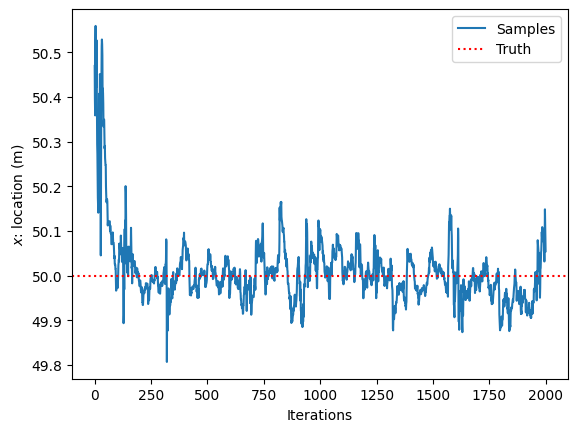

In [29]:
plt.plot(mala_chains["source_x"], label = "Samples")
plt.axhline(source_location.source_location_x, label = "Truth", ls=":", color="r")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("$x$: location (m)")
plt.show()

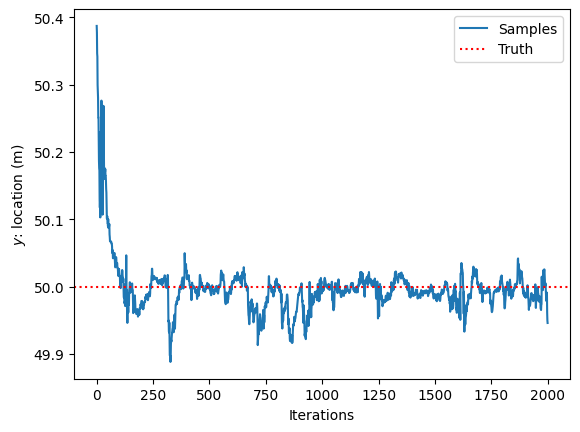

In [30]:
plt.plot(mala_chains["source_y"], label = "Samples")
plt.axhline(source_location.source_location_y, label = "Truth", ls=":", color="r")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("$y$: location (m)")
plt.show()

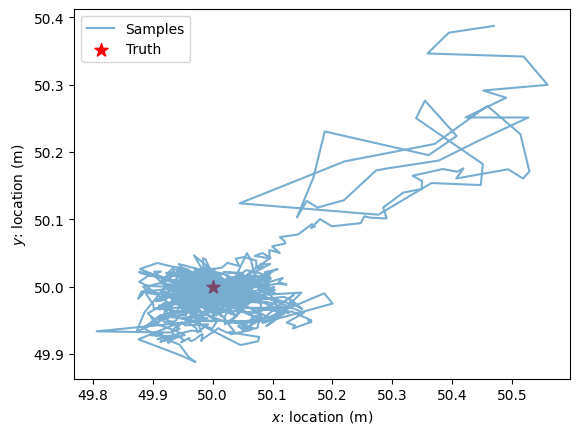

In [31]:
plt.plot(mala_chains["source_x"], mala_chains["source_y"], label = "Samples", alpha=0.6)
plt.scatter(source_location.source_location_x, source_location.source_location_y, label = "Truth", marker="*", color="r", s=100)
plt.legend()
plt.xlabel("$x$: location (m)")
plt.ylabel("$y$: location (m)")
plt.show()

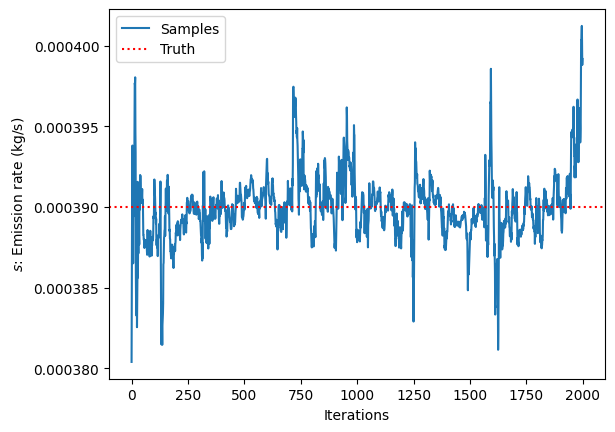

In [32]:
plt.plot(mala_chains["s"], label = "Samples")
plt.axhline(atmospheric_state.emission_rate, label = "Truth", ls=":", color="r")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("$s$: Emission rate (kg/s)")
plt.show()